In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# НАСТРОЙКА И ЗАГРУЗКА ДАННЫХ
N = 17
X_COL_INDEX = (N % 5)
Y_COL_INDEX = (N**2 % 5 + 5)
FILE_PATH = 'students_simple.csv'

try:
    df = pd.read_csv(FILE_PATH)
    
    if X_COL_INDEX >= len(df.columns) or Y_COL_INDEX >= len(df.columns):
        print(f"Ошибка: В датасете меньше столбцов, чем требуется (индексы: {X_COL_INDEX}, {Y_COL_INDEX}).")
        print("Пожалуйста, проверьте файл и индексы.")
        raise FileNotFoundError
        
    X_name = df.columns[X_COL_INDEX]
    Y_name = df.columns[Y_COL_INDEX]

    X = df.iloc[:, X_COL_INDEX]
    Y = df.iloc[:, Y_COL_INDEX]
    
except FileNotFoundError:
    print(f"Файл '{FILE_PATH}' не найден или индексы некорректны.")

print(f"Выбраны столбцы: X='{X_name}', Y='{Y_name}'")

Выбраны столбцы: X='income', Y='test_time'


In [35]:
# РАСЧЕТ КОРРЕЛЯЦИЙ
print("Расчет корреляций")

# Фехнера
X_sign = np.sign(X - X.mean())
Y_sign = np.sign(Y - Y.mean())
concordant = np.sum(X_sign * Y_sign > 0)
discordant = np.sum(X_sign * Y_sign < 0)
r_fechner = (concordant - discordant) / len(X)

# Пирсона
r_pearson = X.corr(Y, method='pearson')
n = len(X)
z = 0.5 * np.log((1 + r_pearson) / (1 - r_pearson))
se_z = 1 / np.sqrt(n - 3)
alpha = 0.05
z_crit = stats.norm.ppf(1 - alpha / 2)
z_min = z - z_crit * se_z
z_max = z + z_crit * se_z
r_min = (np.exp(2 * z_min) - 1) / (np.exp(2 * z_min) + 1)
r_max = (np.exp(2 * z_max) - 1) / (np.exp(2 * z_max) + 1)

# Спирмена
r_spearman, _ = stats.spearmanr(X, Y)

# Кенделла
r_kendall, _ = stats.kendalltau(X, Y)

print(f"Фехнера: {r_fechner:.4f}")
print(f"Пирсона: {r_pearson:.4f} (95% ДИ: [{r_min:.4f}, {r_max:.4f}])")
print(f"Спирмена: {r_spearman:.4f}")
print(f"Кенделла: {r_kendall:.4f}")


Расчет корреляций
Фехнера: -0.4000
Пирсона: -0.5699 (95% ДИ: [-0.8085, -0.1703])
Спирмена: -0.5392
Кенделла: -0.4362


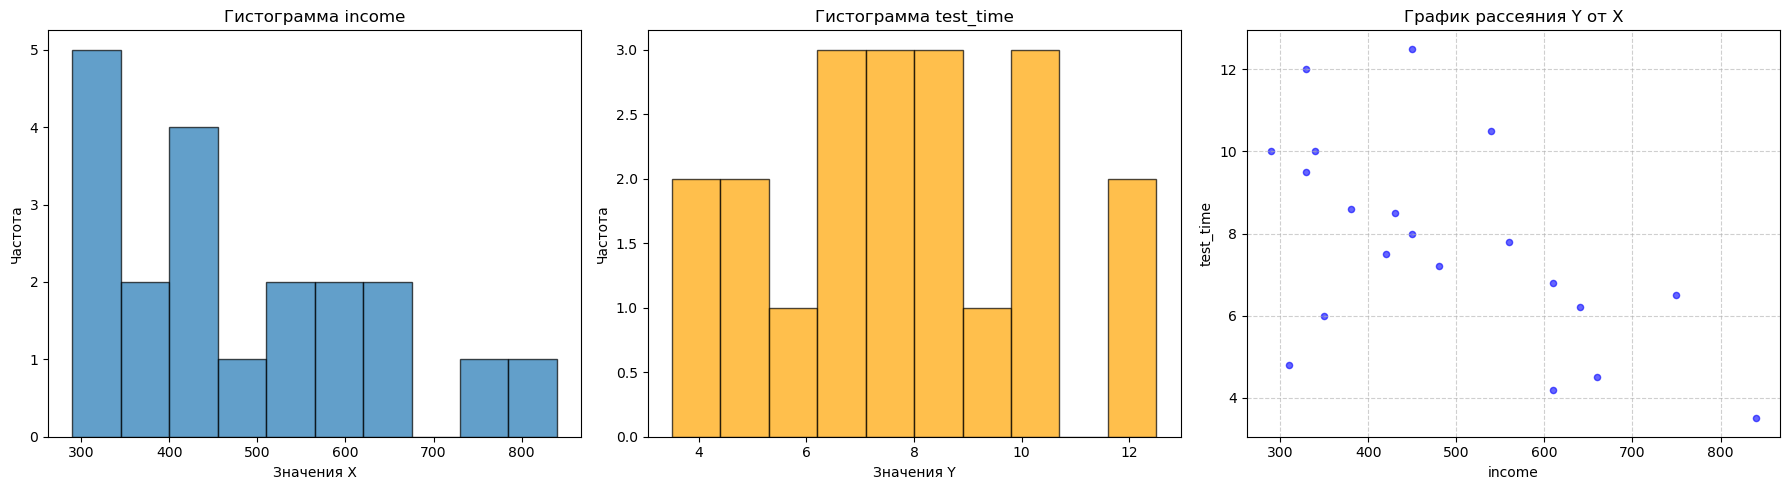

In [37]:
# ВИЗУАЛИЗАЦИЯ

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Гистограммы
ax[0].hist(X, bins=10, edgecolor='black', alpha=0.7)
ax[0].set_title(f'Гистограмма {X_name}')
ax[0].set_xlabel('Значения X')
ax[0].set_ylabel('Частота')

ax[1].hist(Y, bins=10, edgecolor='black', alpha=0.7, color='orange')
ax[1].set_title(f'Гистограмма {Y_name}')
ax[1].set_xlabel('Значения Y')
ax[1].set_ylabel('Частота')

# График рассеяния
ax[2].scatter(X, Y, s=20, color='blue', alpha=0.6)
ax[2].set_title('График рассеяния Y от X')
ax[2].set_xlabel(X_name)
ax[2].set_ylabel(Y_name)
ax[2].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Линейная:       Y = -0.009*X + 12.209 | R^2 = 0.3248
Квадратичная:   Y = -0.000*X^2 + 0.010*X + 7.602 | R^2 = 0.3542
Гиперболическая: Y = 1832.347/X + 3.615 | R^2 = 0.2428
Показательная:  Y = 14.122 * 0.999^X | R^2 = 0.2880


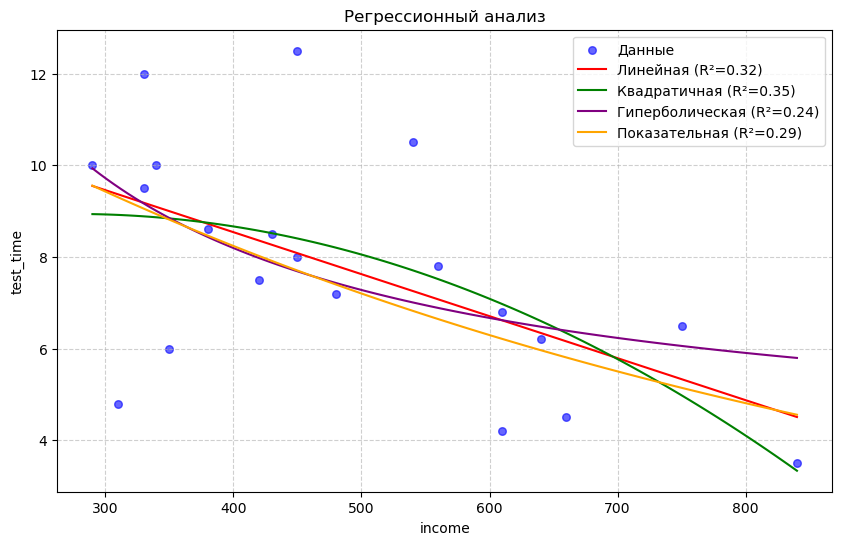

In [38]:
# УРАВНЕНИЕ РЕГРЕССИИ

results = {} # Словарь для хранения R^2 и моделей

# Линейная (Y = w1*X + w0)
X_mean = X.mean()
Y_mean = Y.mean()
w1 = np.sum((X - X_mean) * (Y - Y_mean)) / np.sum((X - X_mean)**2)
w0 = Y_mean - w1 * X_mean

Y_pred_linear = w1 * X + w0
SS_res_linear = np.sum((Y - Y_pred_linear)**2)
SS_tot = np.sum((Y - Y_mean)**2)
R2_linear = 1 - (SS_res_linear / SS_tot)
results['linear'] = {'R2': R2_linear, 'params': f'Y = {w1:.3f}*X + {w0:.3f}'}

# Построение модели для F-критерия
df_lin = pd.DataFrame({'Y': Y, 'X': X})
model_linear_sm = ols('Y ~ X', data=df_lin).fit()

# Квадратичная (Y = w2*X^2 + w1*X + w0)
df_quad = pd.DataFrame({'Y': Y, 'X': X, 'X_sq': X**2})
model_quad = ols('Y ~ X + X_sq', data=df_quad).fit()
Y_pred_quad = model_quad.predict(df_quad)
R2_quad = model_quad.rsquared

w2_quad = model_quad.params['X_sq']
w1_quad = model_quad.params['X']
w0_quad = model_quad.params['Intercept']
results['quadratic'] = {'R2': R2_quad, 'params': f'Y = {w2_quad:.3f}*X^2 + {w1_quad:.3f}*X + {w0_quad:.3f}'}

# Гиперболическая (Y = w1*(1/X) + w0)
# Игнорируем точки, где X=0, если есть
df_hyp = pd.DataFrame({'Y': Y, 'X_inv': 1 / X})
df_hyp = df_hyp.replace([np.inf, -np.inf], np.nan).dropna()
if not df_hyp.empty:
    model_hyp = ols('Y ~ X_inv', data=df_hyp).fit()
    Y_pred_hyp = model_hyp.predict(df_hyp)
    R2_hyp = model_hyp.rsquared

    w1_hyp = model_hyp.params['X_inv']
    w0_hyp = model_hyp.params['Intercept']
    results['hyperbolic'] = {'R2': R2_hyp, 'params': f'Y = {w1_hyp:.3f}/X + {w0_hyp:.3f}'}
else:
    R2_hyp = -1 # Присвоим минимальное R^2, если модель не построена
    results['hyperbolic'] = {'R2': R2_hyp, 'params': 'Модель не построена (X=0)'}


# Показательная (ln(Y) = w1*X + w0') -> Y = w0 * w1^X
# Игнорируем точки, где Y <= 0
df_exp = pd.DataFrame({'ln_Y': np.log(Y[Y > 0]), 'X': X[Y > 0]})
if not df_exp.empty:
    model_exp_ln = ols('ln_Y ~ X', data=df_exp).fit()
    
    w1_prime = model_exp_ln.params['X']
    w0_prime = model_exp_ln.params['Intercept']
    
    w1_exp = np.exp(w1_prime)
    w0_exp = np.exp(w0_prime)
    
    Y_pred_exp = w0_exp * (w1_exp ** X)
    SS_res_exp = np.sum((Y - Y_pred_exp)**2)
    R2_exp = 1 - (SS_res_exp / SS_tot) # R^2 рассчитываем на исходных Y
    results['exponential'] = {'R2': R2_exp, 'params': f'Y = {w0_exp:.3f} * {w1_exp:.3f}^X'}
else:
    R2_exp = -1
    results['exponential'] = {'R2': R2_exp, 'params': 'Модель не построена (Y<=0)'}

print(f"Линейная:       {results['linear']['params']} | R^2 = {results['linear']['R2']:.4f}")
print(f"Квадратичная:   {results['quadratic']['params']} | R^2 = {results['quadratic']['R2']:.4f}")
print(f"Гиперболическая: {results['hyperbolic']['params']} | R^2 = {results['hyperbolic']['R2']:.4f}")
print(f"Показательная:  {results['exponential']['params']} | R^2 = {results['exponential']['R2']:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(X, Y, s=30, label='Данные', color='blue', alpha=0.6)

X_sort = np.linspace(X.min(), X.max(), 100) # Для гладких линий

# Линейная
plt.plot(X_sort, w1 * X_sort + w0, color='red', label=f'Линейная (R²={R2_linear:.2f})')

# Квадратичная
df_quad_pred = pd.DataFrame({'X': X_sort, 'X_sq': X_sort**2})
plt.plot(X_sort, model_quad.predict(df_quad_pred), color='green', label=f'Квадратичная (R²={R2_quad:.2f})')

# Гиперболическая
if R2_hyp != -1:
    # Использование имени параметра
    w1_hyp_plot = model_hyp.params['X_inv']
    w0_hyp_plot = model_hyp.params['Intercept']
    plt.plot(X_sort, w1_hyp_plot / X_sort + w0_hyp_plot, color='purple', label=f'Гиперболическая (R²={R2_hyp:.2f})')

# Показательная
if R2_exp != -1:
    plt.plot(X_sort, w0_exp * (w1_exp ** X_sort), color='orange', label=f'Показательная (R²={R2_exp:.2f})')

plt.title('Регрессионный анализ')
plt.xlabel(X_name)
plt.ylabel(Y_name)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [39]:
# ПРОВЕРКА УРАВНЕНИЯ РЕГРЕССИИ (Критерий Фишера)
print("Прверка уравнения регрессии")

# Определение лучшей и худшей моделей
R2_values = {key: res['R2'] for key, res in results.items() if res['R2'] >= 0}
best_model_name = max(R2_values, key=R2_values.get)
worst_model_name = min(R2_values, key=R2_values.get)

# Получение объектов моделей Statsmodels для F-критерия
model_map = {
    'linear': model_linear_sm,
    'quadratic': model_quad,
    # Для гиперболической и показательной F-критерий берется из OLS-модели для линеаризованных данных
    # Но для корректного сравнения с R^2 лучше использовать линеаризованные модели, если они есть
    'hyperbolic': model_hyp if R2_hyp != -1 else None,
    'exponential': model_exp_ln if R2_exp != -1 else None,
}

# Функция для проверки F-критерия
def check_f_test(model_name, model):
    if model is None:
        print(f"Модель {model_name} не была построена. Проверка невозможна.")
        return
        
    F_stat = model.fvalue
    p_value = model.f_pvalue
    R2 = model.rsquared
    
    # Расчет критического значения F (alpha=0.05)
    k = model.df_model # Число регрессоров
    df2 = model.df_resid # n - k - 1
    F_crit = stats.f.ppf(1 - 0.05, k, df2)
    
    print(f"\nМодель: {model_name.upper()} (R² = {results[model_name]['R2']:.4f})")
    print(f"F-набл: {F_stat:.4f}")
    print(f"F-крит (α=0.05, df1={int(k)}, df2={int(df2)}): {F_crit:.4f}")
    
    if F_stat > F_crit:
        print(f"Вывод: F-набл > F-крит. Модель **статистически значима** (p-value: {p_value:.4f}).")
    else:
        print(f"Вывод: F-набл <= F-крит. Модель **статистически незначима** (p-value: {p_value:.4f}).")

# Проверка наилучшего уравнения
check_f_test(best_model_name, model_map.get(best_model_name))

# Проверка наихудшего уравнения
check_f_test(worst_model_name, model_map.get(worst_model_name))


Прверка уравнения регрессии

Модель: QUADRATIC (R² = 0.3542)
F-набл: 4.6615
F-крит (α=0.05, df1=2, df2=17): 3.5915
Вывод: F-набл > F-крит. Модель **статистически значима** (p-value: 0.0243).

Модель: HYPERBOLIC (R² = 0.2428)
F-набл: 5.7709
F-крит (α=0.05, df1=1, df2=18): 4.4139
Вывод: F-набл > F-крит. Модель **статистически значима** (p-value: 0.0273).
